<a href="https://colab.research.google.com/github/aaronmj7/MSc_project/blob/main/Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In [1]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Dot, Concatenate, Multiply, Attention, GlobalAveragePooling1D
from keras.optimizers import Adam

In [2]:
# Set seaborn theme
sns.set_theme()

## Load Data

In [63]:
# Load movies.csv
movies_df = pd.read_csv('/content/drive/MyDrive/ml-32m/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [64]:
# Load tags.csv
tags_df = pd.read_csv('/content/drive/MyDrive/ml-32m/tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102
...,...,...,...,...
2000067,162279,90645,Rafe Spall,1320817734
2000068,162279,91079,Anton Yelchin,1322337407
2000069,162279,91079,Felicity Jones,1322337400
2000070,162279,91658,Rooney Mara,1325828398


In [65]:
# Load ratings.csv
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-32m/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [66]:
# Load links.csv
links_df = pd.read_csv('/content/drive/MyDrive/ml-32m/links.csv')
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


## EDA

In [7]:
# Display more info

print(movies_df.info(), '\n')
print(tags_df.info(), '\n')
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None


In [8]:
# Check null values
print(movies_df.isnull().sum(), '\n')
print(tags_df.isnull().sum(), '\n')
print(ratings_df.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64 

userId        0
movieId       0
tag          17
timestamp     0
dtype: int64 

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [9]:
# Get rows with null values
tags_df[tags_df['tag'].isnull()]

,userId,movieId,tag,timestamp
185377,27046,33826,NaN,1221450908
1394089,89369,281500,NaN,1670942104
1914668,153443,123,NaN,1199450867
1914669,153443,346,NaN,1199451946
1914673,153443,1184,NaN,1199452261
1914680,153443,1785,NaN,1199452006
1914681,153443,2194,NaN,1199450677
1914683,153443,2691,NaN,1199451002
1914691,153443,4103,NaN,1199451920
1914693,153443,4473,NaN,1199451040


In [10]:
# Drop null values
tags_df.dropna(inplace=True)

In [11]:
# Check shape
tags_df.shape

(2000055, 4)

In [12]:
# Describe statistical info
movies_df.describe()

,movieId
count,87585.000000
mean,157651.365519
std,79013.402099
min,1.000000
25%,112657.000000
50%,165741.000000
75%,213203.000000
max,292757.000000


In [13]:
# Describe statistical info
tags_df.describe()

,userId,movieId,timestamp
count,2.000055e+06,2.000055e+06,2.000055e+06
mean,8.192807e+04,7.189362e+04,1.528916e+09
std,3.810614e+04,7.480377e+04,1.290807e+08
min,2.200000e+01,1.000000e+00,1.135429e+09
25%,6.841300e+04,4.011000e+03,1.473615e+09
50%,7.821300e+04,5.232800e+04,1.574083e+09
75%,1.036980e+05,1.222940e+05,1.614740e+09
max,1.622790e+05,2.926290e+05,1.697155e+09


In [14]:
# Describe statistical info
ratings_df.describe()

,userId,movieId,rating,timestamp
count,3.200020e+07,3.200020e+07,3.200020e+07,3.200020e+07
mean,1.002785e+05,2.931861e+04,3.540396e+00,1.275241e+09
std,5.794905e+04,5.095816e+04,1.058986e+00,2.561630e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,5.005300e+04,1.233000e+03,3.000000e+00,1.051012e+09
50%,1.002970e+05,3.452000e+03,3.500000e+00,1.272622e+09
75%,1.504510e+05,4.419900e+04,4.000000e+00,1.503158e+09
max,2.009480e+05,2.927570e+05,5.000000e+00,1.697164e+09


In [15]:
# Get value count of diferent genres
genre_count = movies_df['genres'].value_counts()
genre_count

,count
genres,
Drama,12443
Documentary,8132
Comedy,7761
(no genres listed),7080
Comedy|Drama,3245
...,...
Animation|Crime|Mystery|Sci-Fi|Thriller,1
Action|Comedy|Crime|Horror|Thriller,1
Adventure|Documentary|Drama|War,1


In [16]:
# Get all genres
all_genres = []
for genres in movies_df['genres']:
  all_genres.extend(genres.split('|'))

all_genres = pd.Series(all_genres)
all_genres.value_counts()

,count
Drama,34175
Comedy,23124
Thriller,11823
Romance,10369
Action,9668
Documentary,9363
Horror,8654
(no genres listed),7080
Crime,6976
Adventure,5402


In [17]:
# Get value count of diferent tags
tags_df['tag'].value_counts()

,count
tag,
sci-fi,10996
atmospheric,9589
action,8473
comedy,8139
funny,7467
...,...
bad behavior,1
apache junction arizona,1
advent calendar,1


In [18]:
# Get value count of diferent ratings
rating_count = ratings_df['rating'].value_counts().sort_index()
rating_count

,count
rating,
0.5,525132
1.0,946675
1.5,531063
2.0,2028622
2.5,1685386
3.0,6054990
3.5,4290105
4.0,8367654
4.5,2974000


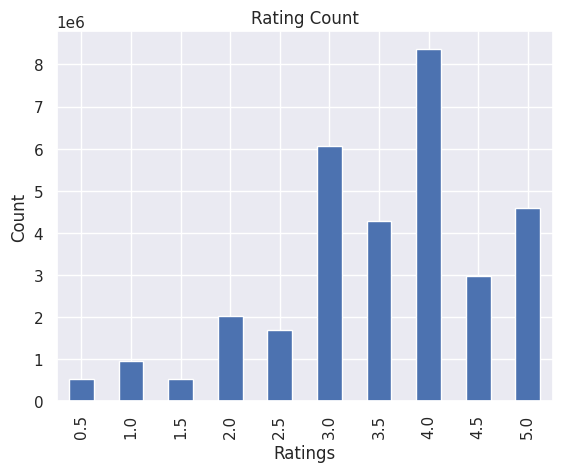

In [19]:
# Plot rating count
rating_count.plot(kind='bar')
plt.title('Rating Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

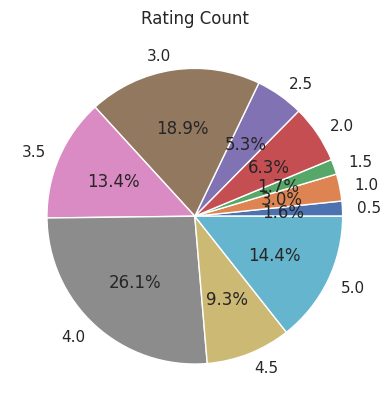

In [20]:
# Plot pie chart of rating count
rating_count.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rating Count')
plt.ylabel('')
plt.show()

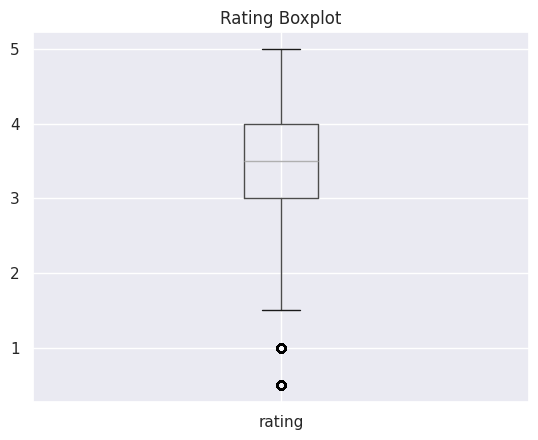

In [21]:
# Plot rating boxplot
ratings_df.boxplot(column='rating')
plt.title('Rating Boxplot')
plt.show()

## Data Pre-processing

In [93]:
# Calculate the average rating for each movie
average_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Set movieId as index
average_ratings_df.set_index('movieId', inplace=True)

# Display average ratings
average_ratings_df

,rating
movieId,
1,3.897438
2,3.275758
3,3.139447
4,2.845331
5,3.059602
...,...
292731,4.000000
292737,1.500000
292753,4.000000


In [94]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.005082
std,0.801820
min,0.500000
25%,2.543478
50%,3.071429
75%,3.500000
max,5.000000


In [95]:
# Round the average ratings to the nearest 0.5
average_ratings_df['rating'] = (average_ratings_df['rating'] * 2).round() / 2

average_ratings_df

,rating
movieId,
1,4.0
2,3.5
3,3.0
4,3.0
5,3.0
...,...
292731,4.0
292737,1.5
292753,4.0


In [96]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.004968
std,0.811505
min,0.500000
25%,2.500000
50%,3.000000
75%,3.500000
max,5.000000


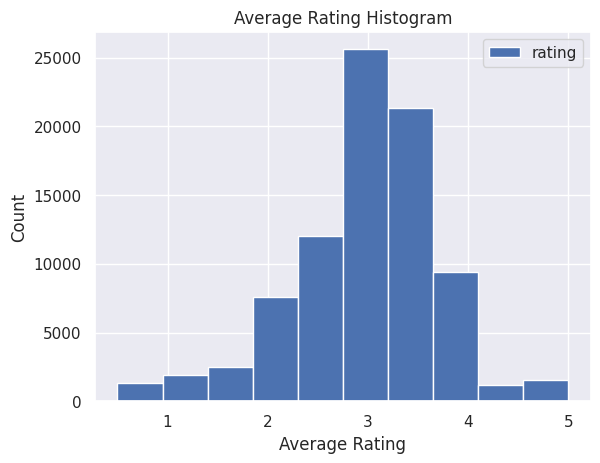

In [97]:
# Plot
average_ratings_df.plot(kind='hist', bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Average Rating Histogram')
plt.show()

In [98]:
movie_tag_counts = tags_df.groupby('movieId').size().reset_index(name='tag_count')

movie_tag_counts.set_index('movieId', inplace=True)

movie_tag_counts

,tag_count
movieId,
1,1230
2,573
3,23
4,12
5,64
...,...
292143,12
292349,1
292371,1


In [99]:
movie_tag_counts.describe()

,tag_count
count,51323.000000
mean,38.970286
std,160.935483
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,6697.000000


In [100]:
movie_tag_counts.median()

,0
tag_count,5.0


Text(0.5, 1.0, 'Tag Count Boxplot')

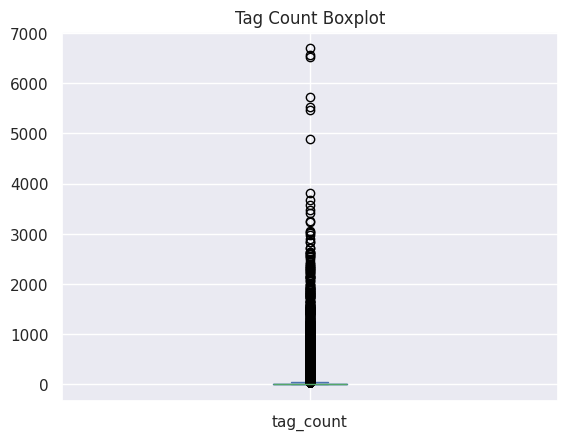

In [101]:
movie_tag_counts.plot(kind='box')
plt.title('Tag Count Boxplot')

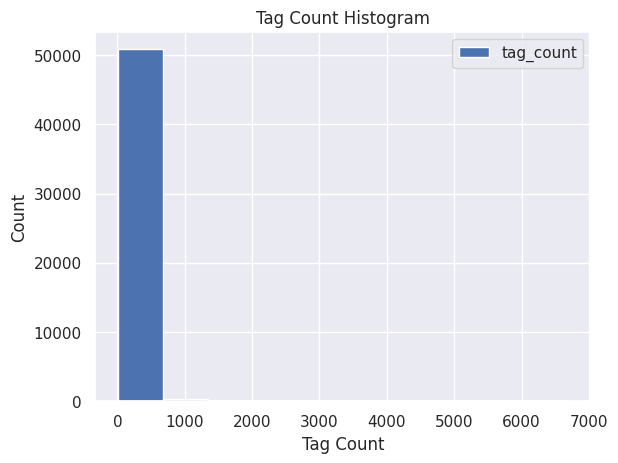

In [102]:
movie_tag_counts.plot(kind='hist', bins=10)
plt.xlabel('Tag Count')
plt.ylabel('Count')
plt.title('Tag Count Histogram')
plt.show()

In [103]:
# Count the occurrences of each tag for each movie
tag_counts_df = tags_df.groupby(['movieId', 'tag']).size().reset_index(name='tag_count')

tag_counts_df

,movieId,tag,tag_count
0,1,1990s,1
1,1,2009 reissue in Stereoscopic 3-D,1
2,1,3 dimensional,1
3,1,3D,3
4,1,3d,1
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [104]:
tag_counts_df.sort_values(by=['movieId', 'tag_count'], ascending=[True, False])

,movieId,tag,tag_count
27,1,Pixar,86
50,1,animation,74
19,1,Disney,54
206,1,funny,50
31,1,Tom Hanks,47
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [105]:
# Take the top n tags for each movie
n = 3
top_tags_df = tag_counts_df.groupby('movieId').head(n)

# Aggregate top tags into a single string for each movie
top_tags_df = top_tags_df.groupby('movieId')['tag'].apply(lambda tags: ', '.join(tags)).reset_index()
top_tags_df.columns = ['movieId', 'top_tags']

# Merge the top tags with average_ratings_df
movies_with_ratings_and_tags_df = pd.merge(average_ratings_df, top_tags_df, on='movieId', how='left')

movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim..."
1,2,3.5,"1860s, 1960s, 1990s"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon"
3,4,3.0,"CLV, based on novel or book, characters"
4,5,3.0,"4th wall, CLV, Comedy"
...,...,...,...
84427,292731,4.0,NaN
84428,292737,1.5,NaN
84429,292753,4.0,NaN
84430,292755,1.0,NaN


In [106]:
movies_with_ratings_and_tags_df.dropna(inplace=True)
movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim..."
1,2,3.5,"1860s, 1960s, 1990s"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon"
3,4,3.0,"CLV, based on novel or book, characters"
4,5,3.0,"4th wall, CLV, Comedy"
...,...,...,...
84360,292057,2.0,illegal immigration
84368,292143,2.5,"Cadaqués, China, Spain"
84379,292349,3.0,politically incorrect
84389,292371,2.5,Stephen King


In [107]:
# Replace '|' with ', ' in the 'genre' column
movies_df['genres'] = movies_df['genres'].str.replace('|', ', ')
movies_df

<ipython-input-107-8a11f283276a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genres'] = movies_df['genres'].str.replace('|', ', ')


,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [108]:
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [109]:
# Calculate the number of genres for each movie
movies_df['genre_count'] = movies_df['genres'].apply(lambda x: len(x.split(', ')))
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [110]:
movies_df['genre_count'].describe()

,genre_count
count,80309.000000
mean,1.816409
std,0.931584
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,5.000000


In [111]:
movies_df[movies_df['genre_count'] > 5]['genres']

,genres


In [112]:
movies_df = movies_df[movies_df['genre_count'] <= 5]
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [113]:
# Merge movies_with_ratings_and_tags_df with genres from movies_df
final_df = pd.merge(movies_with_ratings_and_tags_df, movies_df[['movieId', 'genres']], on='movieId', how='left')
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim...","Adventure, Animation, Children, Comedy, Fantasy"
1,2,3.5,"1860s, 1960s, 1990s","Adventure, Children, Fantasy"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon","Comedy, Romance"
3,4,3.0,"CLV, based on novel or book, characters","Comedy, Drama, Romance"
4,5,3.0,"4th wall, CLV, Comedy",Comedy
...,...,...,...,...
48165,292057,2.0,illegal immigration,Drama
48166,292143,2.5,"Cadaqués, China, Spain",NaN
48167,292349,3.0,politically incorrect,"Comedy, Horror"
48168,292371,2.5,Stephen King,"Fantasy, Horror"


In [114]:
final_df.dropna(inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim...","Adventure, Animation, Children, Comedy, Fantasy"
1,2,3.5,"1860s, 1960s, 1990s","Adventure, Children, Fantasy"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon","Comedy, Romance"
3,4,3.0,"CLV, based on novel or book, characters","Comedy, Drama, Romance"
4,5,3.0,"4th wall, CLV, Comedy",Comedy
...,...,...,...,...
48164,292033,3.0,neighbor,"Comedy, Drama"
48165,292057,2.0,illegal immigration,Drama
48167,292349,3.0,politically incorrect,"Comedy, Horror"
48168,292371,2.5,Stephen King,"Fantasy, Horror"


In [115]:
final_df['rating'].describe()

,rating
count,45891.000000
mean,3.074317
std,0.661412
min,0.500000
25%,3.000000
50%,3.000000
75%,3.500000
max,5.000000


In [116]:
final_df['rating'] = ((final_df['rating'] - 0.5) / 0.45).astype(int)  # This scales the ratings into the range 0-9
final_df['rating'] = np.clip(final_df['rating'], 0, 9)
final_df['rating']

,rating
0,7
1,6
2,5
3,5
4,5
...,...
48164,5
48165,3
48167,5
48168,4


In [117]:
final_df['rating'].value_counts().sort_index()

,count
rating,
0,266
1,456
2,860
3,3166
4,6705
5,15035
6,14073
7,4757
8,287


In [44]:
# Tokenize tags and genres
tokenizer_tags = Tokenizer()
tokenizer_tags.fit_on_texts(final_df['top_tags'].apply(lambda x: ' '.join(x)))
tag_sequences = tokenizer_tags.texts_to_sequences(final_df['top_tags'].apply(lambda x: ' '.join(x)))

tokenizer_genres = Tokenizer()
tokenizer_genres.fit_on_texts(final_df['genres'].apply(lambda x: ' '.join(x)))
genre_sequences = tokenizer_genres.texts_to_sequences(final_df['genres'].apply(lambda x: ' '.join(x)))

In [45]:
# Find the maximum length of sequences for tags and genres
max_tag_length = max(len(seq) for seq in tag_sequences)
max_genre_length = max(len(seq) for seq in genre_sequences)

# Pad sequences to have the same length
tag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')
genre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')

In [118]:
# Prepare inputs and outputs
X_movie_id = final_df['movieId'].values
X_tags = tag_sequences_padded
X_genres = genre_sequences_padded

# Scale ratings from [0.5, 5.0] to [0, 9]
y = final_df['rating'].values

# Train-validation split
X_movie_id_train, X_movie_id_val, X_tags_train, X_tags_val, X_genres_train, X_genres_val, y_train, y_val = train_test_split(
    X_movie_id, X_tags, X_genres, y, test_size=0.1, random_state=7
)

In [119]:
X_movie_id_train.shape, X_tags_train.shape, X_genres_train.shape, y_train.shape

((41301,), (41301, 454), (41301, 40), (41301,))

In [120]:
X_movie_id_val.shape, X_tags_val.shape, X_genres_val.shape, y_val.shape

((4590,), (4590, 454), (4590, 40), (4590,))

## Model

In [121]:
# Model parameters
embedding_dim = 8  # Adjusted embedding dimension

# Model Inputs
movie_input = Input(shape=(1,), name='movie_input')
genre_input = Input(shape=(max_genre_length,), name='genre_input')
tag_input = Input(shape=(max_tag_length,), name='tag_input')

# Embedding Layers for Deep Component
genre_embedding_layer_deep = Embedding(input_dim=len(tokenizer_genres.word_index) + 1, output_dim=embedding_dim)
tag_embedding_layer_deep = Embedding(input_dim=len(tokenizer_tags.word_index) + 1, output_dim=embedding_dim)

# Deep Component with Attention
genre_embeddings_deep = genre_embedding_layer_deep(genre_input)
tag_embeddings_deep = tag_embedding_layer_deep(tag_input)

# Attention mechanism for genres and tags in the deep component
genre_attention = Attention(name="genre_attention")([genre_embeddings_deep, genre_embeddings_deep])
tag_attention = Attention(name="tag_attention")([tag_embeddings_deep, tag_embeddings_deep])

# Concatenate genre and tag attention outputs for interaction
deep_interaction_layer = Concatenate()([
    GlobalAveragePooling1D()(genre_attention),
    GlobalAveragePooling1D()(tag_attention)
])  # pooling to reduce them to the same shape

# Dense layer in deep component to capture high-order interactions
deep_dense_layer = Dense(64, activation='relu')(deep_interaction_layer)

# Embedding Layers for Wide Component
genre_embedding_layer_wide = Embedding(input_dim=len(tokenizer_genres.word_index) + 1, output_dim=embedding_dim)
tag_embedding_layer_wide = Embedding(input_dim=len(tokenizer_tags.word_index) + 1, output_dim=embedding_dim)

# Wide Component with Element-wise Product
genre_embeddings_wide = genre_embedding_layer_wide(genre_input)
tag_embeddings_wide = tag_embedding_layer_wide(tag_input)

# Global Average Pooling to create fixed-length vectors for wide component
genre_pooled_wide = GlobalAveragePooling1D()(genre_embeddings_wide)
tag_pooled_wide = GlobalAveragePooling1D()(tag_embeddings_wide)

# Element-wise product for low-order interactions in the wide component
wide_interaction_layer = Multiply()([genre_pooled_wide, tag_pooled_wide])

# Combine Deep and Wide Components
combined_layer = Concatenate()([deep_dense_layer, wide_interaction_layer])

# Prediction Layer for 10-class classification
output = Dense(10, activation='softmax')(combined_layer)

# Define model
model = Model(inputs=[movie_input, genre_input, tag_input], outputs=output)

# Compile model for classification
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ genre_input (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_input (InputLayer)    │ (None, 454)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 40, 8)          │            160 │ genre_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 454, 8)         │            912 │ tag_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_attention           │ (None, 40, 8)          │              0 │ embedding_12[0][0],    │
│ (Attention)               │                        │                │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_attention (Attention) │ (None, 454, 8)         │              0 │ embedding_13[0][0],    │
│                           │                        │                │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 8)              │              0 │ genre_attention[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 8)              │              0 │ tag_attention[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 40, 8)          │            160 │ genre_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 454, 8)         │            912 │ tag_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 16)             │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 8)              │              0 │ embedding_14[0][0]     │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 8)              │              0 │ embedding_15[0][0]     │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          1,088 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 8)              │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7        

 Total params: 3,962 (15.48 KB)

 Trainable params: 3,962 (15.48 KB)

 Non-trainable params: 0 (0.00 B)

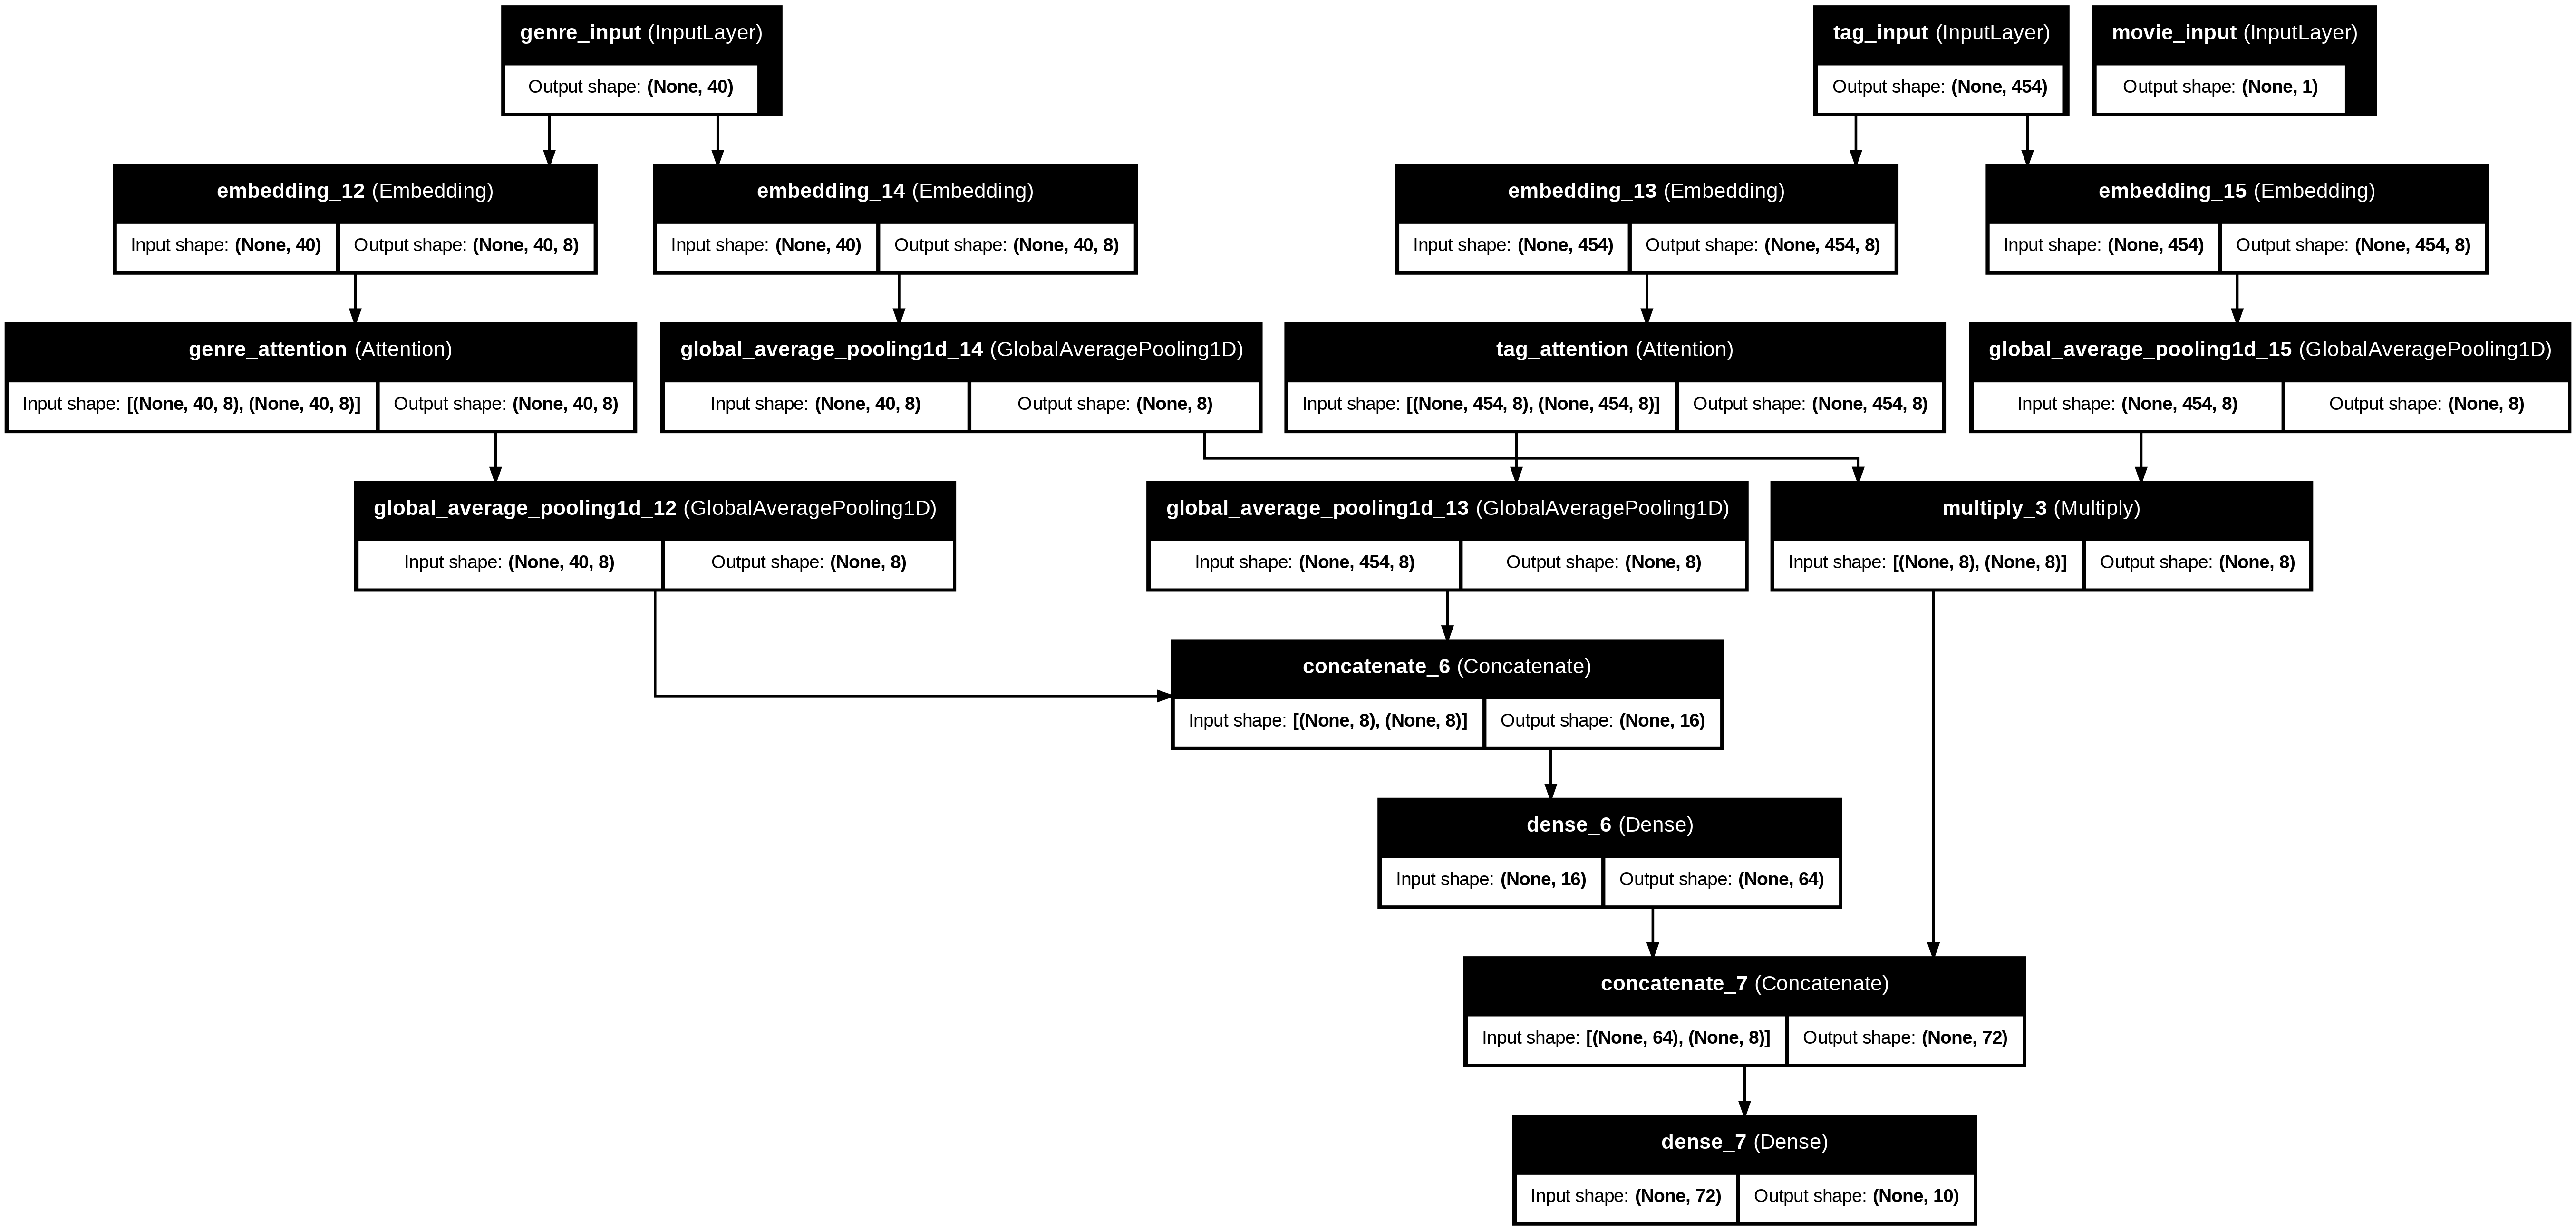

In [122]:
from keras.utils import set_random_seed, plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [123]:
EPOCHS = 2

X_train = [X_movie_id_train, X_genres_train, X_tags_train]
X_val = [X_movie_id_val, X_genres_val, X_tags_val]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS
)

Epoch 1/2
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 167s 127ms/step - accuracy: 0.3290 - loss: 1.6780 - val_accuracy: 0.3632 - val_loss: 1.5838
Epoch 2/2
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 170s 131ms/step - accuracy: 0.3603 - loss: 1.5904 - val_accuracy: 0.3843 - val_loss: 1.5728
